In [1]:
# Run this cell first
!pip install -q tensorflow==2.12.0 scikit-learn matplotlib pillow

import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


In [2]:
# Clone the Houses dataset repository programmatically (no manual download)
# This will place the files in ./Houses-dataset
if not os.path.exists("Houses-dataset"):
    !git clone https://github.com/emanhamed/Houses-dataset.git
else:
    print("Repository already cloned.")


Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165 (from 1)
Receiving objects: 100% (2166/2166), 176.26 MiB | 42.52 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [3]:
# List files to discover structure
for root, dirs, files in os.walk("Houses-dataset"):
    # print a shallow tree (only first two levels) to avoid huge prints
    if root.count(os.sep) - "Houses-dataset".count(os.sep) < 3:
        print(root, "->", len(files), "files")


Houses-dataset -> 3 files
Houses-dataset/Houses Dataset -> 2141 files
Houses-dataset/.git -> 5 files
Houses-dataset/.git/info -> 1 files
Houses-dataset/.git/refs -> 0 files
Houses-dataset/.git/hooks -> 13 files
Houses-dataset/.git/logs -> 1 files
Houses-dataset/.git/objects -> 0 files
Houses-dataset/.git/branches -> 0 files


In [6]:


possible_paths = [
    "Houses-dataset/Houses Dataset/HousesInfo.txt",
    "Houses-dataset/Houses Dataset/HousesInfo.csv",
    "Houses-dataset/HousesInfo.txt",
    "Houses-dataset/dataset.txt",
    "Houses-dataset/Houses Dataset/HousesInfo.txt"
]

meta_path = None
# try likely paths
for p in possible_paths:
    if os.path.exists(p):
        meta_path = p
        break

# fallback: search for any .txt or .csv in the repo root/subdirs
if meta_path is None:
    txt_candidates = []
    for root, _, files in os.walk("Houses-dataset"):
        for f in files:
            if f.lower().endswith((".txt", ".csv")):
                txt_candidates.append(os.path.join(root, f))
    # prefer files with 'house' or 'houses' or 'info' in name
    if len(txt_candidates) > 0:
        meta_path = sorted(txt_candidates, key=lambda x: ('houses' in x.lower() or 'house' in x.lower() or 'info' in x.lower()), reverse=True)[0]

print("Using metadata file:", meta_path)


Using metadata file: Houses-dataset/Houses Dataset/HousesInfo.txt


In [12]:
# The repository note says each line has: bedrooms bathrooms area zipcode price (space or comma separated)
if meta_path is None:
    raise FileNotFoundError("Metadata file not found in repo. Please inspect the repository layout (run previous listing cell).")

# Try to read intelligently
def parse_metadata(path):
    # Try parsing lines directly, as the CSV read seems to fail to produce correct columns
    lines = open(path, "r", encoding="utf-8", errors="ignore").read().strip().splitlines()
    rows = []
    for ln in lines:
        # normalize separators
        ln2 = " ".join(ln.strip().split())
        parts = ln2.replace(",", " ").split()
        # keep only numeric parts
        numeric = []
        for p in parts:
            try:
                numeric.append(float(p))
            except:
                pass
        # Accept rows with >=5 numeric values
        if len(numeric) >= 5:
            # use first 5
            b, bath, area, zipcode, price = numeric[:5]
            rows.append([int(b), int(bath), float(area), int(zipcode), float(price)])
    df = pd.DataFrame(rows, columns=["bedrooms", "bathrooms", "area", "zipcode", "price"])
    print("Parsed metadata from text file with shape", df.shape)
    return df

meta_df = parse_metadata(meta_path)
print("Metadata shape:", meta_df.shape)
display(meta_df.head())

Parsed metadata from text file with shape (535, 5)
Metadata shape: (535, 5)


,bedrooms,bathrooms,area,zipcode,price
0,4,4,4053.0,85255,869500.0
1,4,3,3343.0,36372,865200.0
2,3,4,3923.0,85266,889000.0
3,5,5,4022.0,85262,910000.0
4,3,4,4116.0,85266,971226.0


In [8]:
# find all image files in repo (jpg, png)
img_files = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    img_files.extend(glob.glob(f"Houses-dataset/**/{ext}", recursive=True))
len(img_files), img_files[:5]


(2140,
 ['Houses-dataset/Houses Dataset/425_bathroom.jpg',
  'Houses-dataset/Houses Dataset/195_kitchen.jpg',
  'Houses-dataset/Houses Dataset/12_kitchen.jpg',
  'Houses-dataset/Houses Dataset/290_bedroom.jpg',
  'Houses-dataset/Houses Dataset/45_bathroom.jpg'])

In [9]:
# The repo description says there are 4 images per house.
# We'll group images by a common numeric prefix in filename (e.g., 1_1.jpg, 1_2.jpg or 1.jpg)
import re
from collections import defaultdict

groups = defaultdict(list)
for p in img_files:
    fname = os.path.basename(p)
    # find leading number(s)
    m = re.match(r"(\d+)", fname)
    if m:
        idx = int(m.group(1)) - 1  # dataset description suggests rows are 1-indexed
    else:
        # try to infer from parent directory name
        parent = os.path.basename(os.path.dirname(p))
        m2 = re.match(r"(\d+)", parent)
        if m2:
            idx = int(m2.group(1)) - 1
        else:
            # fallback: use file index group by name hashing
            idx = hash(fname) % len(meta_df)
    groups[idx].append(p)

# Build a mapping DataFrame: each house index -> list of images
mapping = []
for i in range(len(meta_df)):
    imgs = groups.get(i, [])
    mapping.append({"index": i, "images": imgs})

map_df = pd.DataFrame(mapping)
map_df["n_images"] = map_df["images"].apply(len)
print("Mapped images per house (sample):")
print(map_df.head())


Mapped images per house (sample):
   index                                             images  n_images
0      0  [Houses-dataset/Houses Dataset/1_bedroom.jpg, ...         4
1      1  [Houses-dataset/Houses Dataset/2_bathroom.jpg,...         4
2      2  [Houses-dataset/Houses Dataset/3_bedroom.jpg, ...         4
3      3  [Houses-dataset/Houses Dataset/4_frontal.jpg, ...         4
4      4  [Houses-dataset/Houses Dataset/5_bathroom.jpg,...         4


In [14]:
# Combine meta_df with map_df
meta_df = meta_df.reset_index(drop=True)
# Merge based on index
meta_df = meta_df.merge(map_df[["index", "images","n_images"]], left_index=True, right_on="index", how="left")
meta_df = meta_df.drop(columns=["index"]) # Drop the extra index column from the merge
print("After merge:", meta_df.shape)
meta_df = meta_df[meta_df["n_images"] > 0].reset_index(drop=True)
print("After filtering missing images:", meta_df.shape)
meta_df.head()

After merge: (535, 7)
After filtering missing images: (534, 7)


,bedrooms,bathrooms,area,zipcode,price,images,n_images
0,4,4,4053.0,85255,869500.0,"[Houses-dataset/Houses Dataset/1_bedroom.jpg, ...",4.0
1,4,3,3343.0,36372,865200.0,"[Houses-dataset/Houses Dataset/2_bathroom.jpg,...",4.0
2,3,4,3923.0,85266,889000.0,"[Houses-dataset/Houses Dataset/3_bedroom.jpg, ...",4.0
3,5,5,4022.0,85262,910000.0,"[Houses-dataset/Houses Dataset/4_frontal.jpg, ...",4.0
4,3,4,4116.0,85266,971226.0,"[Houses-dataset/Houses Dataset/5_bathroom.jpg,...",4.0


from matplotlib import pyplot as plt
_df_0['bedrooms'].plot(kind='hist', bins=20, title='bedrooms')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['bathrooms'].plot(kind='hist', bins=20, title='bathrooms')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['area'].plot(kind='hist', bins=20, title='area')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['zipcode'].plot(kind='hist', bins=20, title='zipcode')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='bedrooms', y='bathrooms', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='bathrooms', y='area', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='area', y='zipcode', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='zipcode', y='price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_images']
  ys = series['bedrooms']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('n_images', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_images')
_ = plt.ylabel('bedrooms')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_images']
  ys = series['bathrooms']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('n_images', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_images')
_ = plt.ylabel('bathrooms')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_images']
  ys = series['area']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('n_images', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_images')
_ = plt.ylabel('area')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['n_images']
  ys = series['zipcode']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('n_images', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('n_images')
_ = plt.ylabel('zipcode')

from matplotlib import pyplot as plt
_df_12['bedrooms'].plot(kind='line', figsize=(8, 4), title='bedrooms')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['bathrooms'].plot(kind='line', figsize=(8, 4), title='bathrooms')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['area'].plot(kind='line', figsize=(8, 4), title='area')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['zipcode'].plot(kind='line', figsize=(8, 4), title='zipcode')
plt.gca().spines[['top', 'right']].set_visible(False)

In [15]:
# parameters
IMG_SIZE = (128,128)   # small for faster training; increase if GPU and time available
MAX_IMAGES_PER_HOUSE = 4  # take up to 4 images (repo has 4 per house)

def load_and_preprocess_image(path):
    img = load_img(path, target_size=IMG_SIZE)
    arr = img_to_array(img)
    arr = resnet_preprocess(arr)  # ResNet preprocessing (scales appropriately)
    return arr

# We'll create one image tensor per house by averaging CNN features across images,
# but for simplicity here we'll load the first up to MAX_IMAGES_PER_HOUSE, stack them,
# and average before feeding into fusion (we will extract features via CNN later).
X_imgs = []
X_tab = []
y = []

for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
    img_list = sorted(row['images'])[:MAX_IMAGES_PER_HOUSE]
    imgs_for_house = []
    for p in img_list:
        try:
            imgs_for_house.append(load_and_preprocess_image(p))
        except Exception as e:
            print("Failed to load", p, e)
    if len(imgs_for_house) == 0:
        continue
    # stack and take mean along image axis to produce single image per house (simple fusion)
    imgs_arr = np.stack(imgs_for_house, axis=0)
    house_img = imgs_arr.mean(axis=0)   # shape (H, W, C)
    X_imgs.append(house_img)
    # tabular features
    X_tab.append([row['bedrooms'], row['bathrooms'], row['area'], row['zipcode']])
    y.append(row['price'])

X_imgs = np.array(X_imgs, dtype=np.float32)
X_tab = np.array(X_tab, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print("Shapes -> images:", X_imgs.shape, "tabular:", X_tab.shape, "y:", y.shape)


  0%|          | 0/534 [00:00<?, ?it/s]

Shapes -> images: (534, 128, 128, 3) tabular: (534, 4) y: (534,)


In [16]:
# train-test split
X_img_tr, X_img_te, X_tab_tr, X_tab_te, y_tr, y_te = train_test_split(
    X_imgs, X_tab, y, test_size=0.20, random_state=42
)

# scale tabular features
tab_scaler = StandardScaler()
X_tab_tr_scaled = tab_scaler.fit_transform(X_tab_tr)
X_tab_te_scaled = tab_scaler.transform(X_tab_te)

# Save scaler for later use
joblib.dump(tab_scaler, "tab_scaler.joblib")
print("Train sizes:", X_img_tr.shape, X_tab_tr_scaled.shape, y_tr.shape)


Train sizes: (427, 128, 128, 3) (427, 4) (427,)


In [17]:
# Create ResNet50 base (frozen) and produce a feature vector
base_cnn = ResNet50(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
base_cnn.trainable = False  # freeze for feature extraction

# Add small head to reduce features
cnn_input = Input(shape=(*IMG_SIZE, 3), name="image_input")
x = base_cnn(cnn_input, training=False)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
cnn_output = Dense(128, activation="relu", name="img_features")(x)

# Tabular branch
tab_input = Input(shape=(X_tab_tr_scaled.shape[1],), name="tab_input")
t = Dense(64, activation="relu")(tab_input)
t = Dropout(0.2)(t)

# Fuse
combined = Concatenate()([cnn_output, t])
z = Dense(128, activation="relu")(combined)
z = Dropout(0.2)(z)
z = Dense(64, activation="relu")(z)
output = Dense(1, activation="linear", name="price")(z)

model = Model(inputs=[cnn_input, tab_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ image_input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  8,388,864 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_input           │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ tab_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_features        │ (None, 128)       │     32,896 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ img_features[0][… │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price (Dense)       │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,042,817 (122.23 MB)

 Trainable params: 8,455,105 (32.25 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
EPOCHS = 12
BATCH_SIZE = 16

history = model.fit(
    x=[X_img_tr, X_tab_tr_scaled],
    y=y_tr,
    validation_data=([X_img_te, X_tab_te_scaled], y_te),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)


Epoch 1/12
27/27 - 31s - 1s/step - loss: 615308787712.0000 - mae: 579656.6875 - val_loss: 475286142976.0000 - val_mae: 547245.1875
Epoch 2/12
27/27 - 20s - 758ms/step - loss: 399926132736.0000 - mae: 415674.3438 - val_loss: 176831594496.0000 - val_mae: 342727.5625
Epoch 3/12
27/27 - 21s - 774ms/step - loss: 274878595072.0000 - mae: 327142.1875 - val_loss: 164901027840.0000 - val_mae: 295053.8438
Epoch 4/12
27/27 - 21s - 773ms/step - loss: 249268404224.0000 - mae: 307973.6250 - val_loss: 155275804672.0000 - val_mae: 309566.8125
Epoch 5/12
27/27 - 22s - 799ms/step - loss: 237757399040.0000 - mae: 308336.4062 - val_loss: 149415641088.0000 - val_mae: 292382.8125
Epoch 6/12
27/27 - 22s - 816ms/step - loss: 224076316672.0000 - mae: 295619.6250 - val_loss: 144811196416.0000 - val_mae: 289531.7500
Epoch 7/12
27/27 - 21s - 768ms/step - loss: 212040138752.0000 - mae: 285980.4688 - val_loss: 142750351360.0000 - val_mae: 284158.3438
Epoch 8/12
27/27 - 41s - 2s/step - loss: 187064057856.0000 - mae:

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Test MAE: 307255.19
Test RMSE: 390752.37


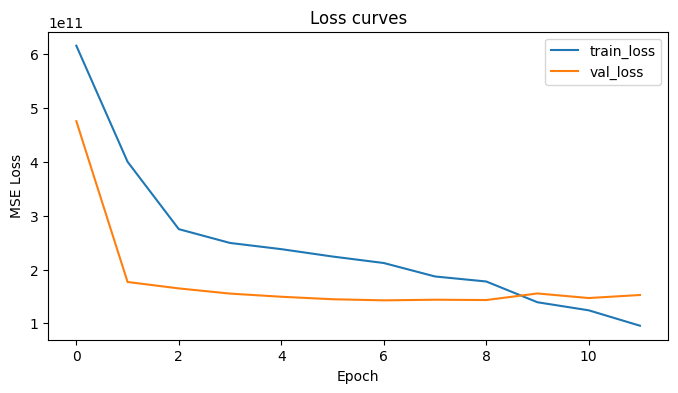

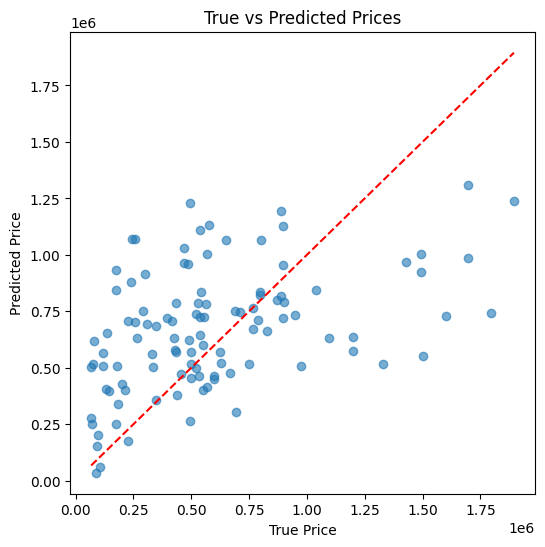

In [19]:
# Predictions
y_pred = model.predict([X_img_te, X_tab_te_scaled]).flatten()

mae = mean_absolute_error(y_te, y_pred)
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

# Plot loss curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Scatter true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_te, y_pred, alpha=0.6)
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Prices")
plt.show()


In [21]:
# We can inspect tabular branch weights roughly: sensitivity analysis (simple)
# For stronger explainability use SHAP or similar tools (not included here for brevity).
# Save model and joblib artifacts
model.save("multimodal_housing_model.keras")   # Keras saved model
joblib.dump({"tab_scaler":"tab_scaler.joblib"}, "artifacts_info.joblib")
print("Saved model and scaler.")

Saved model and scaler.


In [23]:
# Example: given new_house_images (list of file paths) and new_tabular (bedrooms,bathrooms,area,zipcode)
def prepare_house_image_average(img_paths, img_size=IMG_SIZE):
    imgs = []
    for p in img_paths:
        arr = img_to_array(load_img(p, target_size=img_size))
        arr = resnet_preprocess(arr)
        imgs.append(arr)
    return np.mean(np.stack(imgs, axis=0), axis=0)

# load saved model
loaded = tf.keras.models.load_model("multimodal_housing_model.keras")

# Example usage (if you had images)
# new_img = prepare_house_image_average(["Houses-dataset/....jpg", ...])
# new_tab = np.array([[3,2,1500,90210]])
# new_tab_scaled = tab_scaler.transform(new_tab)
# pred_price = loaded.predict([np.expand_dims(new_img,0), new_tab_scaled])
# print("Predicted price:", pred_price[0,0])